<a href="https://colab.research.google.com/github/stefanbringuier/randomonium/blob/main/notebooks/ASE_Phonopy_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ASE Calculator interface testing with Phonopy
**Stefan Bringuier**

[stefanbringuier@gmail.com](mailto:stefanbringuier@gmail.com)

In [1]:
! pip install -U ase
! pip install -U seekpath
! pip install -U phonopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 881.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for phonopy: filename=phonopy-2.21.0-cp310-cp310-linux_x86_64.whl size=505480 sha256=844f8746ab5f4edeb09246019d5cf05def1d651fc97748079db3e390483dedb6
  Stored in directory: /root/.cache/pip/wheels/67/4e/87/dafe2a46f0a7c4a92b09e405e70155bb390a29c0d48545280c
Successfully built phonopy


In [2]:
import matplotlib.pyplot as plt

from ase.atoms import Atoms
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.units import kB
from ase.optimize import FIRE
from ase.constraints import FixAtoms, UnitCellFilter
from ase.spacegroup.symmetrize import FixSymmetry, check_symmetry

from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

In [3]:
calculator = EMT()

In [4]:
copper =  bulk('Cu', 'fcc', a=3.6)
copper.set_calculator(calc=calculator)
copper.set_constraint(FixSymmetry(copper))
opt_structure = UnitCellFilter(copper)
opt = FIRE(opt_structure)
opt.run(fmax=1.0e-4)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 18:55:22       -0.006689*       0.0816
FIRE:    1 18:55:22       -0.006860*       0.0583
FIRE:    2 18:55:22       -0.007020*       0.0178
FIRE:    3 18:55:22       -0.006995*       0.0285
FIRE:    4 18:55:22       -0.007001*       0.0264
FIRE:    5 18:55:22       -0.007011*       0.0223
FIRE:    6 18:55:22       -0.007022*       0.0166
FIRE:    7 18:55:22       -0.007032*       0.0097
FIRE:    8 18:55:22       -0.007036*       0.0021
FIRE:    9 18:55:22       -0.007035*       0.0056
FIRE:   10 18:55:23       -0.007035*       0.0055
FIRE:   11 18:55:23       -0.007035*       0.0053
FIRE:   12 18:55:23       -0.007035*       0.0050
FIRE:   13 18:55:23       -0.007035*       0.0046
FIRE:   14 18:55:23       -0.007036*       0.0041
FIRE:   15 18:55:23       -0.007036*       0.0036
FIRE:   16 18:55:23       -0.007036*       0.0030
FIRE:   17 18:55:23       -0.007036*       0.0022
FI

True

In [5]:
structure =  opt_structure.atoms
phnpy_struct = PhonopyAtoms(
    symbols=structure.get_chemical_symbols(),
    positions=structure.get_positions(),
    cell=structure.get_cell(),
    masses=structure.get_masses(),
    )

In [6]:
def calculate_plot_phonons(d=0.03,n=6):
    phonons = Phonopy(
        phnpy_struct,
        supercell_matrix=[[n, 0, 0],
                          [0, n, 0],
                          [0, 0, n]],
    )
    phonons.generate_displacements(distance=d)
    sets_of_forces = []
    supercells = phonons.get_supercells_with_displacements()

    for d in supercells:
        # Convert back to ASE
        d_ase = Atoms(symbols=d.get_chemical_symbols(),
                      positions=d.get_positions(),
                      cell=d.get_cell(),
                      pbc=True)
        d_ase.set_calculator(calculator)
        forces = d_ase.get_forces()
        sets_of_forces.append(forces)

    phonons.forces = sets_of_forces
    phonons.produce_force_constants()
    phonons.auto_band_structure(npoints=100, plot=True, write_yaml=True)

## Converged Band Structure, displacement=0.03 Ang, supercell = (6,6,6)

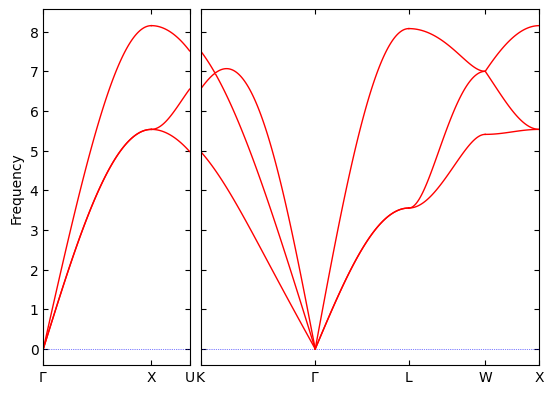

In [7]:
calculate_plot_phonons()

## Displacement, Supercell Scan

In [10]:
import ipywidgets as widgets
from IPython.display import display

interactive(children=(FloatSlider(value=0.03, continuous_update=False, description='Displacement:', max=0.1, m…

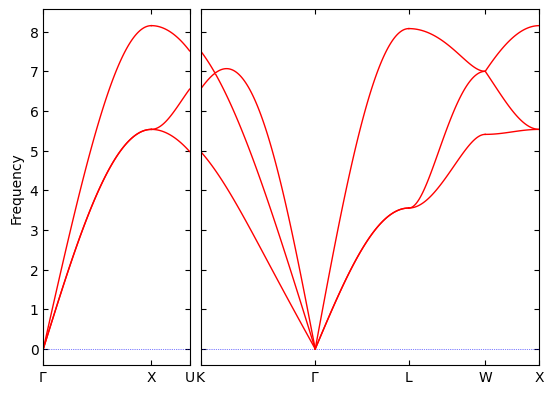

In [11]:
# Create a slider widget for displacement
displacement_slider = widgets.FloatSlider(
    value=0.03,
    min=0.01,
    max=0.1,
    step=0.01,
    description='Displacement:',
    continuous_update=False
)
supercell_slider = widgets.IntSlider(
    value=6,
    min=2,
    max=10,
    step=1,
    description='n x n x n:',
    continuous_update=False
)
# Display the widget and output
widgets.interactive(calculate_plot_phonons,
                    d=displacement_slider,
                    n=supercell_slider)